In [ ]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt

In [2]:
tf.config.list_physical_devices('GPU')

[]

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

In [4]:
def load_video(path:str) -> List[float]: 

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))): 
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[150:215,110:215,:])
    cap.release()
    
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [5]:
vocab = [x for x in " অআইঈউঊঋএঐওঔকখগঘঙচছজঝঞটঠডঢণতথদধনপফবভমযরলশষসহড়ঢ়য়ৎংঃঁািীুূেৈোৌৃ"]

In [8]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} \n"
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', ' ', 'অ', 'আ', 'ই', 'ঈ', 'উ', 'ঊ', 'ঋ', 'এ', 'ঐ', 'ও', 'ঔ', 'ক', 'খ', 'গ', 'ঘ', 'ঙ', 'চ', 'ছ', 'জ', 'ঝ', 'ঞ', 'ট', 'ঠ', 'ড', 'ঢ', 'ণ', 'ত', 'থ', 'দ', 'ধ', 'ন', 'প', 'ফ', 'ব', 'ভ', 'ম', 'য', 'র', 'ল', 'শ', 'ষ', 'স', 'হ', 'ড়', 'ঢ়', 'য়', 'ৎ', 'ং', 'ঃ', 'ঁ', 'া', 'ি', 'ী', 'ু', 'ূ', 'ে', 'ৈ', 'ো', 'ৌ', 'ৃ'] 
(size =62)


In [9]:
char_to_num([' ','অ', 'আ', 'ই', 'ঈ', 'উ', 'ঊ'])

<tf.Tensor: shape=(7,), dtype=int64, numpy=array([1, 2, 3, 4, 5, 6, 7])>

In [22]:
num_to_char([14,  9,  3, 11, 13])

<tf.Tensor: shape=(5,), dtype=string, numpy=
array([b'\xe0\xa6\x96', b'\xe0\xa6\x8f', b'\xe0\xa6\x86', b'\xe0\xa6\x93',
       b'\xe0\xa6\x95'], dtype=object)>

In [11]:
def load_alignments(path:str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
    tokens = []
    for line in lines:
        line = line.split()
        for word in line:
            tokens = [*tokens,' ', word]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [12]:
def load_data(path: str): 
    path = bytes.decode(path.numpy())
    file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    # file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data','person0','clips', f'{file_name}.mp4')
    alignment_path = os.path.join('data','person0','texts',f'{file_name}.txt')
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

In [13]:
# for windows
# test_path = '.\\data\\person0\\clips\\clip0.mp4'
test_path = './data/person0/clips/clip0.mp4'

In [14]:
# for windows
# tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1].split('.')[0]
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('/')[-1].split('.')[0]

'clip0'

In [15]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))
# load_data(tf.convert_to_tensor(test_path))

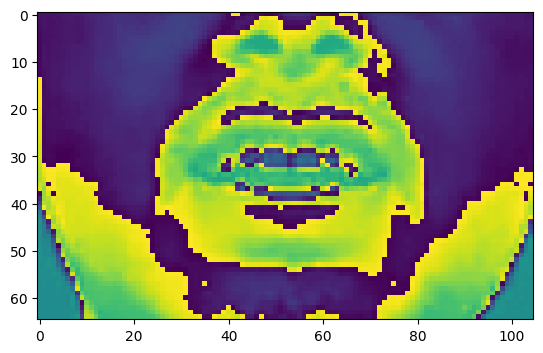

In [17]:
plt.imshow(frames[15])
# frames[23]

In [18]:
# tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])
print([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

['স', 'ে', ' ', 'খ', 'ে', 'ল', 'ত', 'ে', ' ', 'প', 'া', 'র', 'ে', ' ', 'ন', 'া']


In [19]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result